In [3]:
!pip install -q kaggle
# downloads to /content
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:26<00:00, 108MB/s] 
100% 2.29G/2.29G [00:26<00:00, 93.3MB/s]


In [4]:
!unzip -q chest-xray-pneumonia.zip -d /content/raw_data

import shutil, os

raw = "/content/raw_data/chest_xray"
target = "/content/chest_xray"
os.makedirs(target, exist_ok=True)

for folder in ["train", "test", "val"]:
    shutil.move(f"{raw}/{folder}", f"{target}/{folder}")

In [5]:
!find /content/chest_xray -maxdepth 2 -type d -print

/content/chest_xray
/content/chest_xray/test
/content/chest_xray/test/NORMAL
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/train
/content/chest_xray/train/NORMAL
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/val
/content/chest_xray/val/NORMAL
/content/chest_xray/val/PNEUMONIA


### Data Generators (Medical Augmentation Safe)

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH = 32

# Data augmentation for training
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.8,1.2],
    validation_split=0.2   # 20% of train used for validation
)

# Training generator
train = train_gen.flow_from_directory(
    "/content/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='training',   # training subset
    shuffle=True
)

# Validation generator (from the same train folder)
val = train_gen.flow_from_directory(
    "/content/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Test generator remains the same
test = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "/content/chest_xray/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Build DenseNet121 Model (Warm-up Stage)

In [7]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base.trainable = False  # freeze for warm-up

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

### Warm-Up Training

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("best_warmup.h5", save_best_only=True)
]

history1 = model.fit(
    train,
    validation_data=val,
    epochs=8,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.7298 - auc: 0.7023 - loss: 0.5494

131/131 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7304 - auc: 0.7034 - loss: 0.5484 - val_accuracy: 0.9118 - val_auc: 0.9702 - val_loss: 0.2694
Epoch 2/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8964 - auc: 0.9494 - loss: 0.2626

131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 787ms/step - accuracy: 0.8964 - auc: 0.9494 - loss: 0.2625 - val_accuracy: 0.9223 - val_auc: 0.9748 - val_loss: 0.2048
Epoch 3/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9096 - auc: 0.9600 - loss: 0.2301

131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 787ms/step - accuracy: 0.9097 - auc: 0.9600 - loss: 0.2300 - val_accuracy: 0.9425 - val_auc: 0.9840 - val_loss: 0.1689
Epoch 4/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9252 - auc: 0.9687 - loss: 0.1989 - val_accuracy: 0.9386 - val_auc: 0.9815 - val_loss: 0.1705
Epoch 5/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9275 - auc: 0.9749 - loss: 0.1846

131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 803ms/step - accuracy: 0.9275 - auc: 0.9749 - loss: 0.1846 - val_accuracy: 0.9396 - val_auc: 0.9816 - val_loss: 0.1663
Epoch 6/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9285 - auc: 0.9734 - loss: 0.1870

131/131 ━━━━━━━━━━━━━━━━━━━━ 105s 803ms/step - accuracy: 0.9285 - auc: 0.9734 - loss: 0.1870 - val_accuracy: 0.9473 - val_auc: 0.9853 - val_loss: 0.1479
Epoch 7/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 783ms/step - accuracy: 0.9283 - auc: 0.9745 - loss: 0.1799 - val_accuracy: 0.9338 - val_auc: 0.9849 - val_loss: 0.1669
Epoch 8/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 786ms/step - accuracy: 0.9328 - auc: 0.9742 - loss: 0.1796 - val_accuracy: 0.9453 - val_auc: 0.9867 - val_loss: 0.1492


### Fine-Tune Last 30 Layers

In [9]:
for layer in base.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

callbacks_ft = [
    EarlyStopping(patience=4, restore_best_weights=True),
    ModelCheckpoint("best_densenet121.h5", save_best_only=True)
]

history2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callbacks_ft
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.8338 - auc: 0.9534 - loss: 0.4517

131/131 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8340 - auc: 0.9534 - loss: 0.4511 - val_accuracy: 0.9319 - val_auc: 0.9810 - val_loss: 0.1675
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9006 - auc: 0.9676 - loss: 0.2561

131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 788ms/step - accuracy: 0.9006 - auc: 0.9676 - loss: 0.2560 - val_accuracy: 0.9329 - val_auc: 0.9835 - val_loss: 0.1532
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9302 - auc: 0.9737 - loss: 0.1978

131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 787ms/step - accuracy: 0.9302 - auc: 0.9737 - loss: 0.1979 - val_accuracy: 0.9396 - val_auc: 0.9864 - val_loss: 0.1357
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9382 - auc: 0.9821 - loss: 0.1561

131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 797ms/step - accuracy: 0.9382 - auc: 0.9821 - loss: 0.1562 - val_accuracy: 0.9530 - val_auc: 0.9893 - val_loss: 0.1166
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 774ms/step - accuracy: 0.9400 - auc: 0.9805 - loss: 0.1581 - val_accuracy: 0.9482 - val_auc: 0.9882 - val_loss: 0.1233
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 790ms/step - accuracy: 0.9334 - auc: 0.9680 - loss: 0.2024 - val_accuracy: 0.9482 - val_auc: 0.9872 - val_loss: 0.1285
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9364 - auc: 0.9797 - loss: 0.1587

131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 792ms/step - accuracy: 0.9364 - auc: 0.9797 - loss: 0.1587 - val_accuracy: 0.9501 - val_auc: 0.9910 - val_loss: 0.1100
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 783ms/step - accuracy: 0.9393 - auc: 0.9811 - loss: 0.1549 - val_accuracy: 0.9569 - val_auc: 0.9892 - val_loss: 0.1162
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 103s 785ms/step - accuracy: 0.9494 - auc: 0.9825 - loss: 0.1405 - val_accuracy: 0.9549 - val_auc: 0.9900 - val_loss: 0.1147
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9421 - auc: 0.9824 - loss: 0.1484

131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9421 - auc: 0.9824 - loss: 0.1484 - val_accuracy: 0.9616 - val_auc: 0.9920 - val_loss: 0.0971
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9426 - auc: 0.9844 - loss: 0.1409 - val_accuracy: 0.9530 - val_auc: 0.9906 - val_loss: 0.1046
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 781ms/step - accuracy: 0.9468 - auc: 0.9844 - loss: 0.1379 - val_accuracy: 0.9578 - val_auc: 0.9922 - val_loss: 0.1011
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.9546 - auc: 0.9869 - loss: 0.1235

131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 781ms/step - accuracy: 0.9546 - auc: 0.9869 - loss: 0.1236 - val_accuracy: 0.9674 - val_auc: 0.9933 - val_loss: 0.0919
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9473 - auc: 0.9874 - loss: 0.1270 - val_accuracy: 0.9588 - val_auc: 0.9932 - val_loss: 0.0969
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 774ms/step - accuracy: 0.9474 - auc: 0.9859 - loss: 0.1276 - val_accuracy: 0.9578 - val_auc: 0.9935 - val_loss: 0.0941
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 775ms/step - accuracy: 0.9601 - auc: 0.9914 - loss: 0.1027 - val_accuracy: 0.9636 - val_auc: 0.9927 - val_loss: 0.0998
Epoch 17/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9562 - auc: 0.9869 - loss: 0.1245

131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 778ms/step - accuracy: 0.9562 - auc: 0.9869 - loss: 0.1244 - val_accuracy: 0.9664 - val_auc: 0.9960 - val_loss: 0.0795
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 779ms/step - accuracy: 0.9519 - auc: 0.9879 - loss: 0.1229 - val_accuracy: 0.9674 - val_auc: 0.9949 - val_loss: 0.0852
Epoch 19/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 782ms/step - accuracy: 0.9544 - auc: 0.9880 - loss: 0.1196 - val_accuracy: 0.9559 - val_auc: 0.9927 - val_loss: 0.1041
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 772ms/step - accuracy: 0.9661 - auc: 0.9932 - loss: 0.0916 - val_accuracy: 0.9636 - val_auc: 0.9952 - val_loss: 0.0841


### Dynamic Plotting (Fixed Keys)

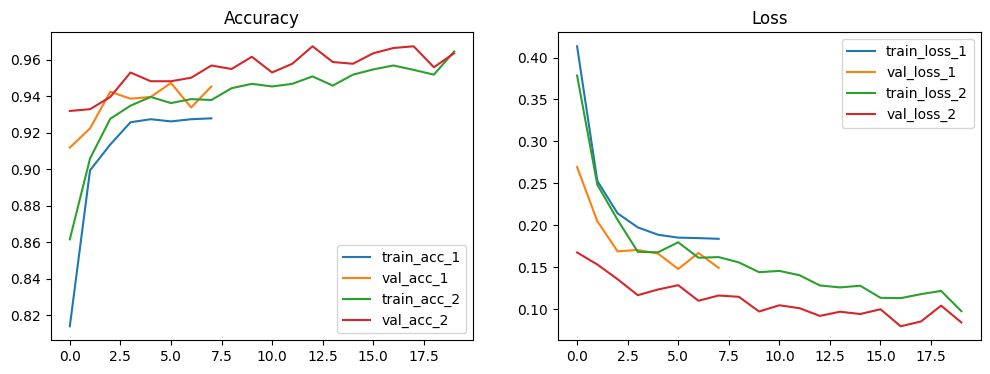

In [13]:
import matplotlib.pyplot as plt

def plot_history(*histories):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    for i,h in enumerate(histories):
        acc = [k for k in h.history.keys() if "accuracy" in k and not k.startswith("val")][0]
        val_acc = [k for k in h.history.keys() if "val" in k and "accuracy" in k][0]
        plt.plot(h.history[acc], label=f"train_acc_{i+1}")
        plt.plot(h.history[val_acc], label=f"val_acc_{i+1}")
    plt.legend()
    plt.title("Accuracy")

    # Loss
    plt.subplot(1,2,2)
    for i,h in enumerate(histories):
        plt.plot(h.history['loss'], label=f"train_loss_{i+1}")
        plt.plot(h.history['val_loss'], label=f"val_loss_{i+1}")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history1, history2)

### Evaluate

In [14]:
test_loss, test_acc, test_auc = model.evaluate(test)
print("Test Accuracy:", test_acc)
print("Test AUC:", test_auc)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.8509 - auc: 0.6432 - loss: 0.4625
Test Accuracy: 0.9054487347602844
Test AUC: 0.965247631072998


### Confusion Matrix + Classification Report

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

pred = model.predict(test)
pred_labels = (pred > 0.5).astype(int)

cm = confusion_matrix(test.classes, pred_labels)
print(cm)

print(classification_report(test.classes, pred_labels, target_names=["NORMAL","PNEUMONIA"]))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step
[[181  53]
 [  6 384]]
              precision    recall  f1-score   support

      NORMAL       0.97      0.77      0.86       234
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624

